# Ensemble - Adaptive Boosting

## References

https://www.kaggle.com/datasets/youssefaboelwafa/credit-card-approval

## Import Python Libraries

In [526]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [527]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [528]:

# Source: https://www.kaggle.com/datasets/youssefaboelwafa/credit-card-approval

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Gender
# X02: Age
# X03: Debt
# X04: Married
# X05: BankCustomer
# X06: EducationLevel
# X07: Ethnicity
# X08: YearsEmployed
# X09: PriorDefault
# X10: Employed
# X11: CreditScore
# X12: DriversLicense
# X13: Citizen
# X14: ZipCode
# X15: Income
#   y: ApprovalStatus

In [529]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/cc_approvals.data'
df0 = pd.read_csv(filepath1, header = None)
df0.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [530]:
# identify X_cols and y_col
df0.columns = df0.columns.astype('str')
all_cols = df0.columns.values
y_col = df0.columns[-1]
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [531]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,y
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [532]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     690 non-null    object 
 1   X02     690 non-null    object 
 2   X03     690 non-null    float64
 3   X04     690 non-null    object 
 4   X05     690 non-null    object 
 5   X06     690 non-null    object 
 6   X07     690 non-null    object 
 7   X08     690 non-null    float64
 8   X09     690 non-null    object 
 9   X10     690 non-null    object 
 10  X11     690 non-null    int64  
 11  X12     690 non-null    object 
 12  X13     690 non-null    object 
 13  X14     690 non-null    object 
 14  X15     690 non-null    int64  
 15  y       690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [533]:
# describe data
df1.describe()

,X03,X08,X11,X15
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [534]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
y      0
dtype: int64

## Data Cleaning and Transformation

In [535]:
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,y
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [536]:
# response column
y_col = new_y_col
y_col

'y'

In [537]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15'],
      dtype='object')

In [538]:
# get unique y_labels
y_labels = ['-', '+']
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'-': 0, '+': 1}

In [539]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,y
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


In [540]:
# remove rows with missing valus
for X in df1.columns.values:
  cond1 = ~((df1[X].isna()))
  df1 = df1.loc[cond1,:]
  
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
y      0
dtype: int64

In [541]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,y
0,2,156,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,1
1,1,328,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,1
2,1,89,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,1
3,2,125,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,1
4,2,43,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,1


In [542]:
# check label distribution
temp = list(y_labels.values())
cond1 = df1.y == temp[0]
cond2 = df1.y == temp[1]

n_1 = np.sum(cond1)
print(temp[0])
print(n_1)

n_2 = np.sum(cond2)
print(temp[1])
print(n_2)

# upsample minority label
df_temp = df1.loc[cond2,:]
n_diff = n_1 - n_2
print(n_diff)

df_upsample = resample(
  df_temp,
  replace = True,
  n_samples = n_diff,
  random_state = random_state
)

# update df1
df1 = pd.concat([df1, df_upsample], ignore_index = True)
df1.info()

0
383
1
307
76
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     766 non-null    int32  
 1   X02     766 non-null    int32  
 2   X03     766 non-null    float64
 3   X04     766 non-null    int32  
 4   X05     766 non-null    int32  
 5   X06     766 non-null    int32  
 6   X07     766 non-null    int32  
 7   X08     766 non-null    float64
 8   X09     766 non-null    int32  
 9   X10     766 non-null    int32  
 10  X11     766 non-null    int64  
 11  X12     766 non-null    int32  
 12  X13     766 non-null    int32  
 13  X14     766 non-null    int32  
 14  X15     766 non-null    int64  
 15  y       766 non-null    int64  
dtypes: float64(2), int32(11), int64(3)
memory usage: 63.0 KB


In [543]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # downsample majority label
# df_temp = df1.loc[cond1,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = False,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # # update df1
# df1 = df1.drop(df_upsample.index)
# df1.info()

In [544]:
# normalize all X_cols
df2 = df1.copy()
# norm = StandardScaler()
# norm = MinMaxScaler()
norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,y
0,0.0,0.140127,-0.457056,0.0,0.0,0.777778,0.0,0.059140,0.0,1.0,0.333333,0.0,0.0,0.219178,-0.012746,1
1,-1.0,1.235669,0.222434,0.0,0.0,0.555556,-1.0,0.700717,0.0,1.0,2.000000,0.0,0.0,-0.561644,1.176845,1
2,-1.0,-0.286624,-0.380880,0.0,0.0,0.555556,-1.0,0.148746,0.0,0.0,0.000000,0.0,0.0,0.602740,1.737653,1
3,0.0,-0.057325,-0.222434,0.0,0.0,0.777778,0.0,0.955197,0.0,1.0,1.666667,1.0,0.0,-0.287671,-0.006373,1
4,0.0,-0.579618,0.399924,0.0,0.0,0.777778,0.0,0.224014,0.0,0.0,0.000000,0.0,2.0,-0.205479,-0.012746,1


## Visualize Dataset

In [545]:
# figure setup
fig_cols = 4
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 20)

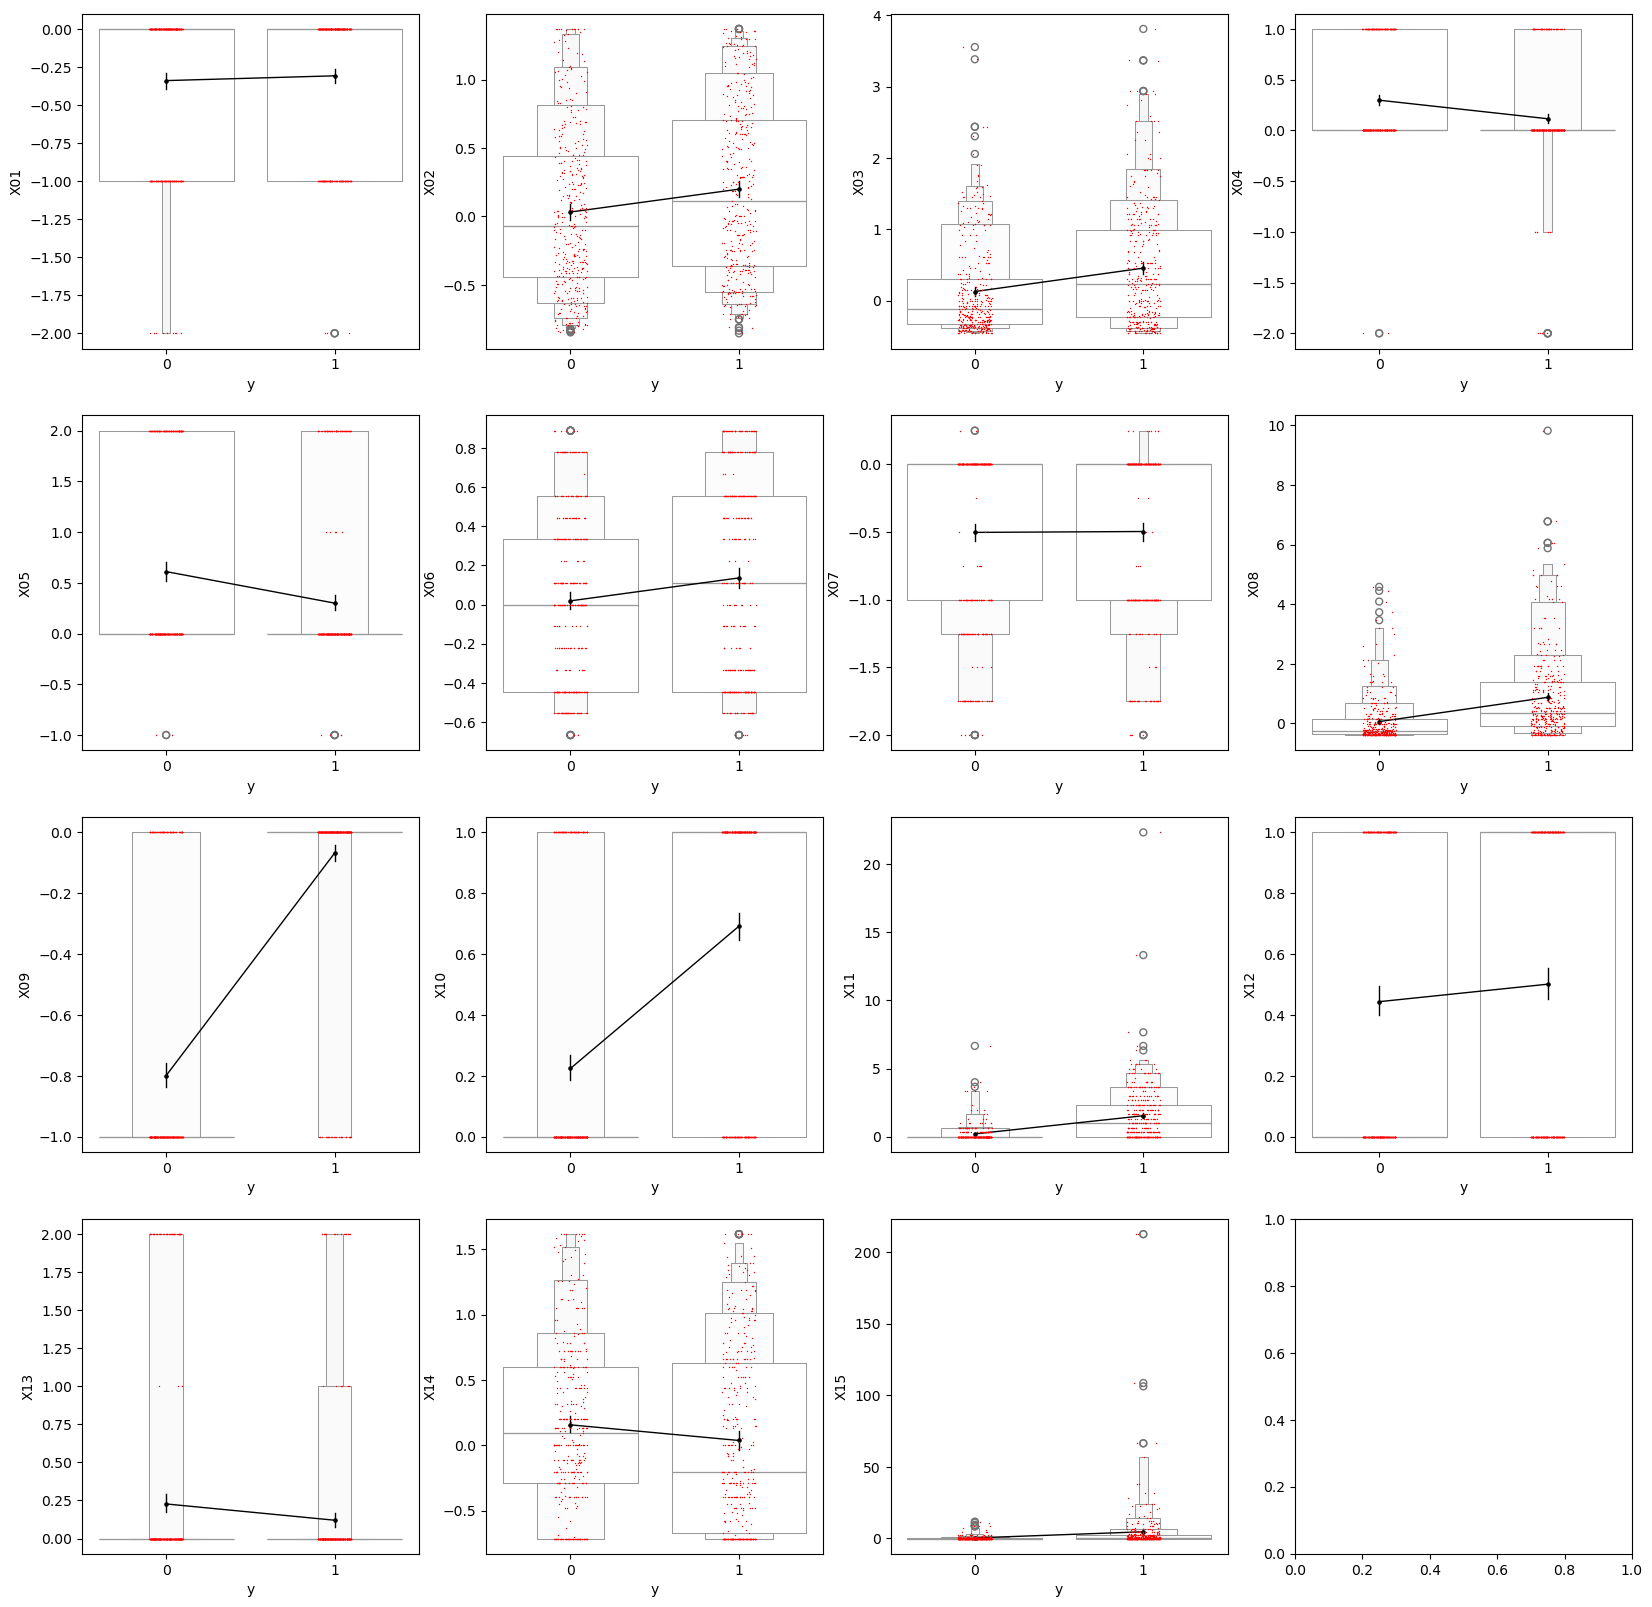

In [546]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [547]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [548]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [549]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(766, 15)

In [550]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15'], dtype=object)

In [551]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15'], dtype=object)

### Select Features Using Model Selection Methods

In [552]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [553]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 20,
  # max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [554]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [555]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.01310766, 0.07375316, 0.07609515, 0.01467727, 0.01689982,
       0.05134443, 0.02610044, 0.10818133, 0.3026558 , 0.0411483 ,
       0.10636958, 0.00799114, 0.00897563, 0.07787936, 0.07482092])

In [556]:
# threshold feature importance
# feature_importance_threshold = np.mean(feature_importance)
feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.75)
feature_importance_threshold

0.05134442998274148

In [557]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [558]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [559]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X02', 'X03', 'X06', 'X08', 'X09', 'X11', 'X14', 'X15'],
      dtype=object)

## Train and Test ML Model

In [560]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
# X_include = ['X03', 'X05', 'X10']
print(len(X_include))
print(X_include)

8
['X02' 'X03' 'X06' 'X08' 'X09' 'X11' 'X14' 'X15']


In [561]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  stratify = y, shuffle = True, 
  train_size = 0.8, random_state = random_state
)

In [562]:
# initialize estimtor model 
estimator_model = RandomForestClassifier(
  random_state = random_state
)

In [563]:
# initialize Bagging Model
myfit = AdaBoostClassifier(
  estimator = estimator_model, 
  n_estimators = 100,
  random_state = random_state
)

In [564]:
# fit model
temp = myfit.fit(X_train, y_train)

In [565]:
# get predictions on test data
y_hat = myfit.predict(X_test)

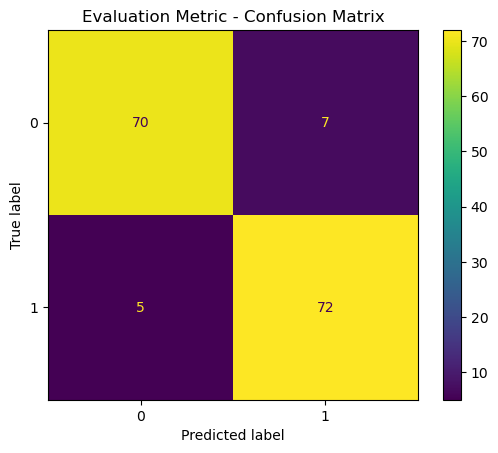

In [566]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [567]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        77
           1       0.91      0.94      0.92        77

    accuracy                           0.92       154
   macro avg       0.92      0.92      0.92       154
weighted avg       0.92      0.92      0.92       154



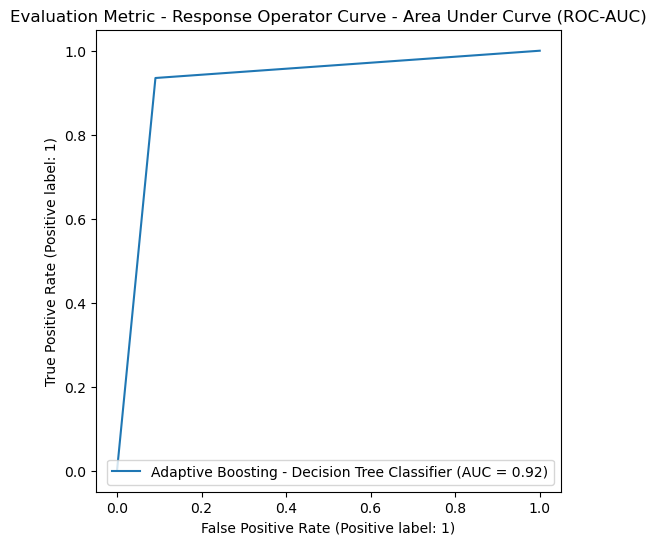

In [568]:
# model evaluation - AUC
fig, ax = plt.subplots(figsize = (6, 6))
RocCurveDisplay.from_predictions(ax = ax,
  y_true = y_test, y_pred = y_hat, pos_label = 1,
  name = "Adaptive Boosting - Random Forest Classifier"
)
plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
plt.show()